In [123]:
import sys, os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from tqdm.notebook import tqdm, trange
from time import sleep


TEST_PERCENTAGE = 0.1
LABELS = np.array([0, 1])

# Disable print
def blockPrint():
    sys.stdout = open(os.devnull, "w")

# Enable print
def unblockPrint():
    sys.stdout = sys.__stdout__

# load from diabetes data set
def loadDataset(file_name):
    data = pd.read_csv("data/" + file_name)
    # print(data.head())
    data = data.to_numpy()
    random.seed(20)
    random.shuffle(data)
    no_rows = data.shape[0]
    train = data[:int((1-TEST_PERCENTAGE)*no_rows)]
    test = data[int((1-TEST_PERCENTAGE)*no_rows):]

    return train, test


# misclassification rate
def getMisclassificationRate(data):
    class_count = np.zeros(len(LABELS), dtype = int)

    for i in range(len(data)):
        label = data[i][-1]                  # getting label
        idx = int(np.argwhere(LABELS == label))   # finding index in LABELS
        class_count[idx] += 1
    prob = class_count[np.argmax(class_count)]/len(data)
    miscls = 1-prob
    miscls = round(miscls,2)
    return miscls


# gini index
def getGiniIndex(data):
    class_count = np.zeros(len(LABELS), dtype = int)

    for i in range(len(data)):
        label = data[i][-1]                  # getting label
        idx = int(np.argwhere(LABELS == label))   # finding index in LABELS
        class_count[idx] += 1
    gini = 1
    # print(class_count)
    for i in range(len(LABELS)):
        if class_count[i] == 0:
            continue
        # print(class_count[i], len(data))
        gini -= (class_count[i]/len(data))**2
    gini = round(gini,5)

    return gini


def getSplit(train_data):

    gini = getGiniIndex(train_data)                         # splitting criterion
    # print(f"Gini index current node: {gini}")

    best_split = np.zeros((8, 2))                           # store best split for each feature
    for col in range(train_data.shape[1]-1):                # loop for every feature
        
        feature = train_data[:,np.r_[col,-1]]

        feature_temp = feature[:,0]
        if len(feature_temp) == 0:                          # if branch is pure break the loop
            break

        max_val = round(feature_temp[np.argmax(feature_temp)], 2)
        min_val = round(feature_temp[np.argmin(feature_temp)], 2)
        step_size = round((max_val - min_val)/100, 2)

        if step_size == 0:
            step_size = 0.01

        for step in np.arange(min_val, max_val, step_size): # incrementing possible split values

            # -----------------------------------------------------------------------

            left = []      # array of values below or equal to threshold and labels
            right = []     # array of values above threshold and labels
            for item in range(len(feature)):

                if feature[item][0] <= step:          # left
                    left.append(feature[item])
                else:                                 # right
                    right.append(feature[item])

            #------------------------------------------------------------------------

            # left = [item for item in feature if item[0] <= step]
            # right = [item for item in feature if item[0] > step]

            #------------------------------------------------------------------------

            # left = np.argwhere(feature[:,0] <= step)
            # right = np.argwhere(feature[:,0] > step)
            # left_idx = np.reshape(left, (1,left.shape[0]))[0]
            # right_idx = np.reshape(right, (1,right.shape[0]))[0]

            # left = feature[left_idx,:]
            # right = feature[right_idx,:]

            #------------------------------------------------------------------------

            giniL = getGiniIndex(left)
            giniR = getGiniIndex(right)

            # percentage of classification improved with split
            improv = gini - (len(left)/len(feature))*giniL - (len(right)/len(feature))*giniR    # misclass of current node - misclass of generated nodes
            improv = round(improv, 2)                                                          # always has to be positive

            if improv > best_split[col][0]:
                best_split[col][0] = improv
                best_split[col][1] = step

        # break
    # print(best_split)
    feature = np.argmax(best_split[:,0])
    split = round(best_split[np.argmax(best_split[:,0]),1], 2)
    improvement = best_split[np.argmax(best_split[:,0]),0]

    return feature, split


def getNodePoints(train_data, feature, split):

    left_idx = np.argwhere(train_data[:,feature] <= split)
    left_idx = np.reshape(left_idx, (1,left_idx.shape[0]))[0]

    right_idx = np.argwhere(train_data[:,feature] > split)
    right_idx = np.reshape(right_idx, (1,right_idx.shape[0]))[0]

    left_node = np.array(train_data[left_idx, :])
    right_node = np.array(train_data[right_idx, :])

    return left_node, right_node


def getNodeClassification(data):

    if len(data) == 0:                       # if empty node
        classification = None
        return classification

    no_zeros = np.argwhere(data[:,-1] == 0)
    no_ones = np.argwhere(data[:,-1] == 1)

    if no_zeros.shape[0] == 0:
        classification = 1
        return classification
    elif no_ones.shape[0] == 0:
        classification = 0
        return classification


    classification = np.argmax([no_zeros.shape[0], no_ones.shape[0]])

    return classification


class Node():
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None
        if len(self.data) != 0:
            self.classification = getNodeClassification(self.data)
        else:
            self.classification = None

        self.feature, self.split = getSplit(self.data)
        self.data_left, self.data_right = getNodePoints(self.data, self.feature, self.split)


class Tree():
    def __init__(self, node):
        self.root = node
        self.depth = 0
        self.splits_lst = []

    def add(self, node, lst, cur_layer):
        queue = []
        queue.append(node)
        #count = 0

        while len(queue) > 0:

            lst.append([queue[0].feature, queue[0].split])
            node = queue.pop(0)

            if node.left != None:
                queue.append(node.left)
                queue.append(node.right)
            else:
                if len(node.data) != 0:
                    node.left = Node(node.data_left)
                    node.right = Node(node.data_right)
                    #count += 1
                    cur_layer.append(node.left.data)      # when leaf node is added add data
                    cur_layer.append(node.right.data)


    def addLayer(self):
        self.depth += 1
        # print(f"-----Adding layer: {self.depth}-----")
        
        cur_layer = []
        self.splits_lst = []
        self.add(self.root, self.splits_lst, cur_layer)

        acc_data = cur_layer
        correct = 0
        incorrect = 0
        for i in range(len(acc_data)):

            dat = acc_data[i][:,-1]

            zero = len(np.argwhere(dat==0))
            one = len(np.argwhere(dat==1))

            if zero > one:
                correct += zero
                incorrect += one
            else:
                correct += one
                incorrect += zero
            # print(zero, one)
        #print(correct, incorrect)
        
        accuracy = round(correct/(correct + incorrect),3)

        # print(f"Training Accuracy: {accuracy}")
        return accuracy

    def dfs(self, node, lst):

        lst.append([node.feature, node.split, node.classification])

        if node.left != None and node.right != None:
            for idx in [node.left, node.right]:
                self.dfs(idx,lst)


    def testTree(self, data):
        correct_class = 0
        for t in data:
            node = self.root
            final_node = self.root
            while node.left != None and node.classification != None:
                if t[node.feature] <= node.split:
                    node = node.left
                else:
                    node = node.right

                final_node = node
            if final_node.classification == t[-1]:
                correct_class += 1

        accuracy = round(correct_class/len(data),3)
        # print(f"Test Accuracy: {accuracy}\n")
        return accuracy


    def getDataClassification(self, data):

        node = self.root
        final_node = self.root
        while node.left != None and node.classification != None:
            # print(node.classification)
            if data[node.feature] <= node.split:
                node = node.left
            else:
                node = node.right

            final_node = node

        data_class = final_node.classification
        return data_class


def train_test(depth, train_data, test_data):

    tree = Tree(Node(train_data))
    acc_train = tree.testTree(train_data)
    acc_test = tree.testTree(test_data)
    print_data = [[0, acc_train, acc_test]]
    if depth == 0:
        print(f"Test Accuracy: {acc_test}")
        pass
    else:
        label = 1
        for i in trange(depth, desc = "Adding Layers --------->"):
            acc_train = tree.addLayer()
            acc_test = tree.testTree(test_data)
            print_data.append([i+1, acc_train, acc_test])
            sleep(0.01)
            label += 1
        
        print(f"Training Accuracy: {acc_train}")
        print(f"Test Accuracy: {acc_test}")

    return tree, print_data


In [127]:
### DEFINE DATASET ###
file_name = "datasets_228_482_diabetes.csv"
# file_name = "data_banknote_authentication.csv"
train, test = loadDataset(file_name)

### tree = train_test(depth, train_data, test_data) ###
tree, print_data = train_test(15, train, test)


Training Accuracy: 0.999
Test Accuracy: 0.87


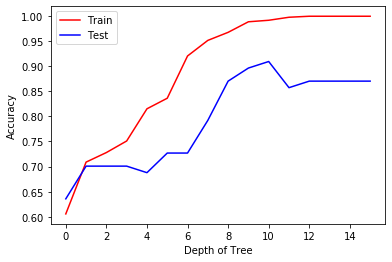

In [128]:
plt.plot([i[0] for i in print_data],[i[1] for i in print_data], label = "Train", color = "red")
plt.plot([i[0] for i in print_data],[i[2] for i in print_data], label = "Test", color = "blue")
plt.xlabel("Depth of Tree")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [131]:
### Classify New Data Here ###
# data = test[2]
# print(data)
# print(tree.getDataClassification(data))

print(f"Accuracies for each Layer: {print_data}\n")

# lst = []
# tree.dfs(tree.root, lst)
# print(f"Terminal Nodes: {lst}\n")
# print(f"Number of Terminal Nodes: {len(lst)}")

# TODO:
# print data and add column with classification
# write to file

Accuracies for each Layer: [[0, 0.606, 0.636], [1, 0.709, 0.701], [2, 0.728, 0.701], [3, 0.751, 0.701], [4, 0.815, 0.688], [5, 0.836, 0.727], [6, 0.92, 0.727], [7, 0.951, 0.792], [8, 0.967, 0.87], [9, 0.988, 0.896], [10, 0.991, 0.909], [11, 0.997, 0.857], [12, 0.999, 0.87], [13, 0.999, 0.87], [14, 0.999, 0.87], [15, 0.999, 0.87]]

